In [45]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize
from tqdm import tqdm
from xgboost import XGBRegressor
import copy
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [47]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [48]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [59]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='inner')

In [58]:
merged_df.shape

(4343, 186)

In [51]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [34]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [35]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [43]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

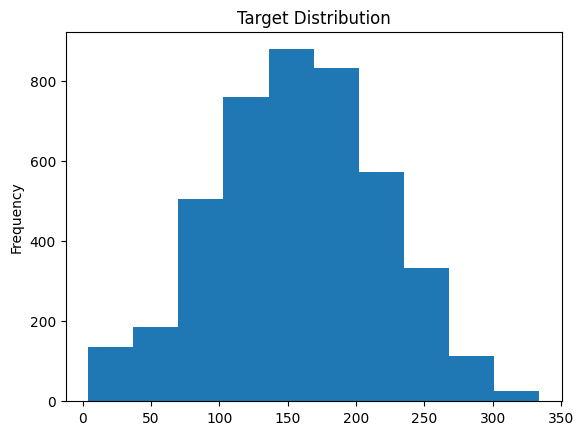

In [37]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [38]:
# create new features by combining 2003 and 2012 scores and numbering ordinal variables
def feature_engineering(data):
    data['rjob_hrswk_change'] = (data['rjob_hrswk_12'] - data['rjob_hrswk_03']).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12']-data['hincome_03']).astype(float)
    data['niadl_change']=(data['n_iadl_12']-data['n_iadl_03']).astype(float)
    data['adl_change']=(data['n_adl_12']-data['n_adl_03']).astype(float)
    data['depr_change']=(data['n_depr_12']-data['n_depr_03']).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_change']=(data['glob_hlth_12']-data['glob_hlth_03']).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_change']=(data['bmi_12']-data['bmi_03']).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_change']=(data['edu_gru_12']-data['edu_gru_03']).astype(float)
    data['illnesses_change']=(data['n_illnesses_12']-data['n_illnesses_03']).astype(float)
    return data

In [39]:
def feature_engineering(data):
    data['rjob_hrswk_change']=data['rjob_hrswk_12'].fillna(0)-data['rjob_hrswk_03'].fillna(0).astype(float)
    data['rjob_hrswk']=data[['rjob_hrswk_03','rjob_hrswk_12']].mean(axis=1).astype(float)
    data['max_work_year']=data[['rjob_end_12','rjob_end_03']].max(axis=1).astype(float)
    data['years_since_work']=(data['year']-data['max_work_year']).astype(float)
    data['hincome_change']=(data['hincome_12'].fillna(0)-data['hincome_03'].fillna(0)).astype(float)
    data['niadl_change']=(data['n_iadl_12'].fillna(0)-data['n_iadl_03'].fillna(0)).astype(float)
    data['adl_max']=(data[['n_adl_12','n_adl_03']].fillna(0)).max(axis=1).astype(float)
    data['iadl_max']=(data[['n_iadl_12','n_iadl_03']].fillna(0)).max(axis=1).astype(float)
    data['neg_adl']=6-data['adl_max']
    data['neg_iadl']=4-data['iadl_max']
    data['adl_change']=(data['n_adl_12'].fillna(0)-data['n_adl_03'].fillna(0)).astype(float)
    data['depr_change']=(data['n_depr_12'].fillna(0)-data['n_depr_03'].fillna(0)).astype(float)
    data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['glob_hlth']=data[['glob_hlth_03', 'glob_hlth_12']].sum(axis=1).astype(float)
    data['bmi_03']=data['bmi_03'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi_12']=data['bmi_12'].replace({'1. Underweight': 1, '2. Normal weight': 2, '3. Overweight':3, '4. Obese':4, '5. Morbidly obese':5}).astype(float)
    data['bmi']=data[['bmi_03', 'bmi_12']].sum(axis=1).astype(float)
    data['employment_03']=data['employment_03'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['employment_12']=data['employment_12'].replace({'1. Currently Working': 'Working', '2. Currently looking for work':'Looking for work', '3. Dedicated to household chores': 'House', '4. Retired, incapacitated, or does not work': 'No work'})
    data['memory_12']=data['memory_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
    data['edu_gru_03']=data['edu_gru_03'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['edu_gru_12']=data['edu_gru_12'].replace({'0. No education':0,'1. 1–5 years':1, '2. 6 years':2, '3. 7–9 years':3,'4. 10+ years':4}).astype(float)
    data['urban_03']=data['urban_03'].fillna(0).replace({ '1. 100,000+':2, '0. <100,000':1}).astype(float)
    data['urban_12']=data['urban_03'].fillna(0).replace({ '1. 100,000+':2, '0. <100,000':1}).astype(float)
    data['issste']=data[['issste_03', 'issste_12']].fillna(0).max(axis=1).astype(float)
    data['urban']=data[['urban_03', 'urban_12']].max(axis=1).astype(float)
    data['edu_gru']=data[['edu_gru_03', 'edu_gru_12']].max(axis=1).astype(float)
    data['hincome']=data[['hincome_03', 'hincome_12']].max(axis=1).astype(float)
    data['illnesses']=data[['n_illnesses_03', 'n_illnesses_12']].max(axis=1).astype(float)
    data['alc_tob_03']=data[['alcohol_03','tobacco_03']].sum(axis=1).astype(float)
    data['alc_tob_12']=data[['alcohol_12','tobacco_12']].sum(axis=1).astype(float)
    data['alc_tob']=data[['alc_tob_03', 'alc_tob_12']].max(axis=1).astype(float)
    data['rearnings']=data[['rearnings_03', 'rearnings_12']].max(axis=1).astype(float)
    data.drop(columns=['issste_03', 'issste_12','urban_03', 'urban_12','edu_gru_03', 'edu_gru_12','bmi_03', 'bmi_12','alc_tob_03', 'alc_tob_12','alcohol_03','tobacco_03','alcohol_12','tobacco_12','hincome_03', 'hincome_12' ], inplace=True)
    return data

In [40]:
def get_cat_cols(data):
    # Get the columns with object datatype
    cat_columns=[]
    dummies=[]
    for col in data.columns:
        if data[col].dtype=='object' and 'uid' not in col:
            cat_columns.append(col)
            dummies.append(col)
        elif data[col].dtype!='object' and 'uid' not in col and (data[col].max()==1.0):
            cat_columns.append(col)
            data[col].fillna(0, inplace=True)
        else:
            continue
    return cat_columns, dummies

In [41]:
def encode_cat_cols(train_data, cat_cols, dummy_cols):
    enc = OneHotEncoder()
    enc.fit(train_data[dummy_cols])
    encoded_train_data=enc.transform(train_data[dummy_cols]).toarray()
    feature_names = enc.get_feature_names_out(dummy_cols)
    train_data.drop(columns=dummy_cols, inplace=True)
    encoded_train_df = pd.DataFrame(encoded_train_data, columns=feature_names)
    train_data[feature_names]=encoded_train_df[feature_names]
    return train_data, feature_names

In [42]:
y=merged_df['composite_score']
data_processed=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data_processed = feature_engineering(data_processed)
cat_cols, dummy_cols = get_cat_cols(data_processed)
data_processed, dummy_feature_names=encode_cat_cols(data_processed, cat_cols, dummy_cols)
data_processed=data_processed.drop(columns=['composite_score'],axis=1)

for col in data_processed.columns: 
    if round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>50:
        data_processed.drop(columns=col, inplace=True)
    elif round((data_processed[col].isna().sum() /len(data_processed)*100), 2)>5:
        print(col,round((data_processed[col].isna().sum() /len(data_processed)*100), 2), '% missing')
        data_processed[col].fillna(0, inplace=True)
    else: 
        data_processed[col].fillna(0, inplace=True)
        data_processed[col].fillna(0, inplace=True)

/tmp/ipykernel_4088657/3657557729.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_4088657/3657557729.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_4088657/3657557729.py:17: FutureWarning: Downcasting behavior i

n_mar_03 33.83 % missing
glob_hlth_03 36.99 % missing
n_adl_03 33.5 % missing
n_iadl_03 36.99 % missing
n_depr_03 37.1 % missing
n_illnesses_03 33.31 % missing
decis_personal_03 37.17 % missing
glob_hlth_12 5.8 % missing
n_iadl_12 5.84 % missing
n_depr_12 6.52 % missing
memory_12 6.72 % missing
rearnings_03 33.37 % missing
searnings_03 49.98 % missing
hinc_business_03 32.98 % missing
hinc_rent_03 32.98 % missing
hinc_assets_03 32.98 % missing
hinc_cap_03 32.98 % missing
rinc_pension_03 33.37 % missing
sinc_pension_03 49.98 % missing
searnings_12 35.19 % missing
sinc_pension_12 35.19 % missing
rjob_hrswk 44.62 % missing


/tmp/ipykernel_4088657/3102208485.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_processed[col].fillna(0, inplace=True)
/tmp/ipykernel_4088657/3102208485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [16]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data = feature_engineering(data)
data=data.drop(columns=['composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

/tmp/ipykernel_4088657/3657557729.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_03']=data['glob_hlth_03'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_4088657/3657557729.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['glob_hlth_12']=data['glob_hlth_12'].replace({'5. Poor':0, '4. Fair':1, '3. Good':2, '2. Very good': 3, '1. Excellent':4}).astype(float)
/tmp/ipykernel_4088657/3657557729.py:17: FutureWarning: Downcasting behavior i

In [17]:
#separate train and test
merged_df_processed=data_processed[:len(merged_df)]
merged_test_processed=data_processed[len(merged_df):]

In [18]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [19]:
merged_df.shape

(4343, 192)

In [20]:
merged_df_processed.shape

(4343, 344)

In [21]:
scaler=MinMaxScaler()

In [24]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []
unique_uids = merged_df['uid'].unique()  # Extract unique uids

for train_ids, val_ids in tqdm(KFold(n_splits=5, shuffle=True, random_state=42).split(unique_uids)):
    # Split the data
    train_uids, val_uids = unique_uids[train_ids], unique_uids[val_ids]
    keep_train = merged_df['uid'].isin(train_uids)
    keep_val = merged_df['uid'].isin(val_uids)
    
    train_X, val_X = merged_df[keep_train], merged_df[keep_val]
    train_X.drop(columns=['uid'], inplace=True)
    val_X.drop(columns=['uid'], inplace=True)
    train_y, val_y = y[keep_train], y[keep_val]
    cats = train_X.select_dtypes(include=['object', 'category']).columns.to_list()
    
    
    train_X_processed, val_X_processed = merged_df_processed[keep_train], merged_df_processed[keep_val]
    train_X_processed.drop(columns=['uid'], inplace=True)
    val_X_processed.drop(columns=['uid'], inplace=True)

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')

    # Define parameters
    params = {
        'objective': 'regression',  # default for regression
        'metric': 'rmse',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_seed': 42
    }

    # Train the model with early stopping
    model1 = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=cats,
        verbose=100, early_stopping_rounds=500
    )
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)
    
    # Train XGBoost
    model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)
    
    # Train Random Forest
    model4 = RandomForestRegressor(n_estimators=1000, random_state=42)
    model4.fit(train_X_processed, train_y)
    pred4 = model4.predict(val_X_processed)
    print("RandomForest rmse: ", root_mean_squared_error(val_y, pred4))

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3, w4 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3 + w4 * pred4
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/4, 1/4, 1/4, 1/4]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3 +
        optimized_weights[3] * pred4
    )

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


0it [00:00, ?it/s]/tmp/ipykernel_4088657/812947124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2145
[LightGBM] [Info] Number of data points in the train set: 3458, number of used features: 191
[LightGBM] [Info] Start training from score 155.317235
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[566]	valid_0's rmse: 41.4669
0:	learn: 60.4168030	test: 61.5679009	best: 61.5679009 (0)	total: 18.8ms	remaining: 3m 8s
100:	learn: 44.5937991	test: 47.6170005	best: 47.6170005 (100)	total: 1.97s	remaining: 3m 12s
200:	learn: 38.1907064	test: 43.6678466	best: 43.6678466 (200)	total: 3.98s	remaining: 3m 13s
300:	learn: 34.5961904	test: 42.3948259	best: 42.3948259 (300)	total: 6.11s	remaining: 3m 16s
400:	learn: 32.2537629	test: 41.8220734	best: 41.8220734 (400)	total: 8.29s	remaining: 3m 18s

1it [02:06, 126.22s/it]

RandomForest rmse:  41.748259451021795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2123
[LightGBM] [Info] Number of data points in the train set: 3481, number of used features: 191
[LightGBM] [Info] Start training from score 157.507613
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_4088657/812947124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:24: S

Early stopping, best iteration is:
[513]	valid_0's rmse: 40.8943
0:	learn: 60.4857861	test: 61.3455246	best: 61.3455246 (0)	total: 71ms	remaining: 11m 50s
100:	learn: 44.8053371	test: 47.3094533	best: 47.3094533 (100)	total: 2.2s	remaining: 3m 35s
200:	learn: 38.5413460	test: 43.0965590	best: 43.0965590 (200)	total: 4.38s	remaining: 3m 33s
300:	learn: 35.1087586	test: 41.6177492	best: 41.6177492 (300)	total: 6.49s	remaining: 3m 29s
400:	learn: 32.6986038	test: 41.0700953	best: 41.0700953 (400)	total: 8.79s	remaining: 3m 30s
500:	learn: 31.0166469	test: 40.7906204	best: 40.7906204 (500)	total: 11.3s	remaining: 3m 34s
600:	learn: 29.8005535	test: 40.6769969	best: 40.6769969 (600)	total: 13.3s	remaining: 3m 28s
700:	learn: 28.5662821	test: 40.5586240	best: 40.5581302 (694)	total: 15.7s	remaining: 3m 28s
800:	learn: 27.4737915	test: 40.5081112	best: 40.5081112 (800)	total: 18.1s	remaining: 3m 27s
900:	learn: 26.5661569	test: 40.4544409	best: 40.4525333 (896)	total: 20.5s	remaining: 3m 27s


2it [04:37, 141.14s/it]

RandomForest rmse:  41.66423377920627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 3477, number of used features: 191
[LightGBM] [Info] Start training from score 158.134311
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_4088657/812947124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:24: S

Early stopping, best iteration is:
[719]	valid_0's rmse: 40.7245
0:	learn: 61.4127208	test: 57.4644721	best: 57.4644721 (0)	total: 19.6ms	remaining: 3m 16s
100:	learn: 44.9142543	test: 45.8914122	best: 45.8914122 (100)	total: 2.07s	remaining: 3m 22s
200:	learn: 38.5028299	test: 42.8167070	best: 42.8167070 (200)	total: 4.18s	remaining: 3m 23s
300:	learn: 35.1051353	test: 41.7391575	best: 41.7391575 (300)	total: 6.35s	remaining: 3m 24s
400:	learn: 32.8633241	test: 41.2051487	best: 41.2051487 (400)	total: 8.47s	remaining: 3m 22s
500:	learn: 31.3277293	test: 40.9920666	best: 40.9904539 (499)	total: 10.7s	remaining: 3m 22s
600:	learn: 30.0056054	test: 40.8528742	best: 40.8526631 (599)	total: 12.9s	remaining: 3m 21s
700:	learn: 28.8019366	test: 40.7679185	best: 40.7679185 (700)	total: 15.1s	remaining: 3m 19s
800:	learn: 27.6942961	test: 40.6962643	best: 40.6962072 (797)	total: 17.3s	remaining: 3m 19s
900:	learn: 26.7630937	test: 40.6603686	best: 40.6576572 (898)	total: 19.6s	remaining: 3m 18

3it [07:16, 149.28s/it]

RandomForest rmse:  41.427066112917274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 3474, number of used features: 191
[LightGBM] [Info] Start training from score 156.698043
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_4088657/812947124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:24: S

Early stopping, best iteration is:
[641]	valid_0's rmse: 41.3587
0:	learn: 60.7821425	test: 60.1902740	best: 60.1902740 (0)	total: 18.3ms	remaining: 3m 3s
100:	learn: 45.0383170	test: 46.8658886	best: 46.8658886 (100)	total: 1.91s	remaining: 3m 6s
200:	learn: 38.7973291	test: 42.9138207	best: 42.9138207 (200)	total: 3.94s	remaining: 3m 12s
300:	learn: 35.3267313	test: 41.5486686	best: 41.5486686 (300)	total: 6.25s	remaining: 3m 21s
400:	learn: 33.1527358	test: 40.9036930	best: 40.9029538 (399)	total: 8.54s	remaining: 3m 24s
500:	learn: 31.4253161	test: 40.5662281	best: 40.5639344 (499)	total: 10.7s	remaining: 3m 22s
600:	learn: 30.1282700	test: 40.4129507	best: 40.4116121 (597)	total: 13s	remaining: 3m 23s
700:	learn: 29.0150620	test: 40.3082729	best: 40.3060203 (699)	total: 15.4s	remaining: 3m 24s
800:	learn: 28.0039996	test: 40.2173545	best: 40.2164407 (798)	total: 17.8s	remaining: 3m 23s
900:	learn: 27.0990307	test: 40.1462811	best: 40.1422933 (894)	total: 20s	remaining: 3m 22s
1000

4it [10:06, 157.24s/it]

RandomForest rmse:  41.794125470922005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 3482, number of used features: 191
[LightGBM] [Info] Start training from score 157.416140
Training until validation scores don't improve for 500 rounds


/tmp/ipykernel_4088657/812947124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X_processed.drop(columns=['uid'], inplace=True)
/tmp/ipykernel_4088657/812947124.py:24: S

Early stopping, best iteration is:
[869]	valid_0's rmse: 40.9353
0:	learn: 60.0797906	test: 62.9789894	best: 62.9789894 (0)	total: 19.3ms	remaining: 3m 12s
100:	learn: 44.8446074	test: 48.2909896	best: 48.2909896 (100)	total: 2.05s	remaining: 3m 20s
200:	learn: 38.6815887	test: 43.5882581	best: 43.5882581 (200)	total: 4.22s	remaining: 3m 25s
300:	learn: 35.2845062	test: 41.8294993	best: 41.8294993 (300)	total: 6.37s	remaining: 3m 25s
400:	learn: 33.0506511	test: 41.0769311	best: 41.0769311 (400)	total: 8.83s	remaining: 3m 31s
500:	learn: 31.5091834	test: 40.6672291	best: 40.6672291 (500)	total: 11s	remaining: 3m 29s
600:	learn: 30.0792993	test: 40.4652895	best: 40.4652895 (600)	total: 13.3s	remaining: 3m 27s
700:	learn: 29.0223375	test: 40.3624922	best: 40.3605087 (688)	total: 15.5s	remaining: 3m 25s
800:	learn: 27.9885733	test: 40.2379044	best: 40.2379044 (800)	total: 17.7s	remaining: 3m 23s
900:	learn: 26.9698613	test: 40.1478093	best: 40.1478093 (900)	total: 20.3s	remaining: 3m 25s


5it [12:39, 151.90s/it]

RandomForest rmse:  40.820906211712305
Average MSE across folds: 40.19116875561459
Optimized weights per fold: [array([0.10237139, 0.42061016, 0.24973412, 0.22728433]), array([1.60207136e-01, 7.45050522e-01, 1.73531489e-12, 9.47423422e-02]), array([0.29020075, 0.3958741 , 0.25102614, 0.06289901]), array([0.        , 0.84613693, 0.13997827, 0.0138848 ]), array([1.24265178e-18, 6.76841564e-01, 1.50446706e-01, 1.72711730e-01])]


In [25]:
print(f"Average MSE across folds: {np.mean(fold_results)}")

Average MSE across folds: 40.19116875561459


In [26]:
np.mean(optimized_weights_list, axis=0)

array([0.11606159, 0.53419643, 0.18496891, 0.16477308])

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
train_data = lgb.Dataset(merged_df, label=y, categorical_feature='auto')

params = {
    'objective': 'regression',  # default for regression
    'metric': 'rmse',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_seed': 42
}
final_model1 = lgb.train(
    params,
    train_data
)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)
final_model2.fit(merged_df, y)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42, 
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(merged_df, y)

# Train Random Forest
final_model4 = RandomForestRegressor(n_estimators=1000, random_state=42)
final_model4.fit(merged_df_processed, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(merged_test)
test_pred2 = final_model2.predict(merged_test)
test_pred3 = final_model3.predict(merged_test)
test_pred4 = final_model4.predict(merged_test_processed)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3 + average_weights[3] * test_pred4
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('../dataset/LGBM_and_CatBoost_and_XGBoost_RandomForest_engineering.csv', index=False)

/u/spa-d4/grad/mfe261/Projects/PREPARE/envs/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2030
[LightGBM] [Info] Number of data points in the train set: 4343, number of used features: 195
[LightGBM] [Info] Start training from score 157.016809
0:	learn: 60.6706359	total: 5.27ms	remaining: 52.7s
100:	learn: 45.1469297	total: 2.03s	remaining: 3m 19s
200:	learn: 39.1364111	total: 4.27s	remaining: 3m 28s
300:	learn: 35.8111622	total: 6.59s	remaining: 3m 32s
400:	learn: 33.7047091	total: 8.94s	remaining: 3m 33s
500:	learn: 32.1122361	total: 11.2s	remaining: 3m 31s
600:	learn: 30.7861504	total: 13.4s	remaining: 3m 28s
700:	learn: 29.6481136	total: 15.7s	remaining: 3m 28s
800:	learn: 28.6747853	total: 18s	remaining: 3m 27s
900:	learn: 27.7920805	total: 20.5s	remaining: 3m 26s
1000:	learn: 26.9744507	total: 23s	remaining: 3m 26s
110